In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

## Basis function

In [146]:
def identity_basis(x):
    ret = np.expand_dims(x, axis=0)
    return ret

def multinomial_basis(x, feature_num=10):
    x = np.expand_dims(x, axis=0)
    ret = x.copy()
    for i in range(feature_num - 1):
        poly = np.power(x, i+2)
        ret = np.append(ret, poly)
    return ret

def gaussian_basis(x, feature_num=10, width_scale=1.0):
    x = np.expand_dims(x, axis=0)
    x_c = np.tile(x, feature_num)
    mus = np.linspace(0, 25, feature_num)
    #mus = np.linspace(x.min(axis=0), x.max(axis=0), feature_num).reshape(-1)
    #sigma = (x.max(axis=0) - x.min(axis=0)) / 6
    sigma = width_scale * (mus[1] - mus[0])
    ret = np.exp(-0.5 * np.square((x_c - mus) / sigma))
    return ret

## Data Loading

In [147]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, file_path):
        super().__init__()
        self.file_path = file_path

    def __getitem__(self, index, transform=gaussian_basis):
        x, y = np.loadtxt(self.file_path)[index]
        x = transform(x)
        x = torch.FloatTensor(x)
        y = np.expand_dims(y, axis=0)
        y = torch.FloatTensor(y)
        return x, y

    def __len__(self):
        return np.loadtxt(self.file_path).shape[0]

In [148]:
train_dataset = Dataset('train.txt')
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=32,
                                           shuffle=True)

test_dataset = Dataset('test.txt')
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=None,
                                           shuffle=False)

train_dsp_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=None,
                                               shuffle=False)

## Model, Criterion (Loss) & Optimizer

In [150]:
in_feat_size = train_dataset[0][0].shape[0]
out_size = 1
num_epochs = 1000
learning_rate = 1e-1

model = nn.Linear(in_feat_size, out_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training & Evaluation

In [151]:
losses = []
count = 0

for epoch in range(num_epochs):
    for x, y in train_loader:
        out = model(x)

        loss = criterion(out, y)
        losses.append(loss.item())
        count += 1

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}.')

losses = np.array(losses)

Epoch 100/1000, Loss: 2.7518.
Epoch 200/1000, Loss: 2.3919.
Epoch 300/1000, Loss: 1.8879.
Epoch 400/1000, Loss: 1.2583.
Epoch 500/1000, Loss: 1.1469.
Epoch 600/1000, Loss: 0.8117.
Epoch 700/1000, Loss: 0.7981.
Epoch 800/1000, Loss: 0.4330.
Epoch 900/1000, Loss: 0.5245.
Epoch 1000/1000, Loss: 0.7042.


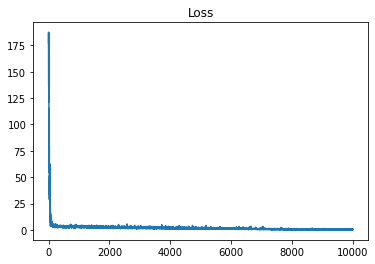

In [153]:
plt.plot(np.arange(count)+1, losses)
plt.title('Loss')
plt.show()

In [154]:
def get_std_pred(model, data_loader):
    num_samples = 0
    acc_loss = 0
    preds = []
    with torch.no_grad():
        for x, y in data_loader:
            num_samples += 1
            y_pred = model(x)
            preds.append(y_pred.numpy())
            loss = criterion(y_pred, y)
            acc_loss += loss.item()

    std = np.sqrt(acc_loss/num_samples)
    preds = np.array(preds)

    return std, preds

In [155]:
std_train, pred_train = get_std_pred(model, train_dsp_loader)
std_test, pred_test = get_std_pred(model, test_loader)

print(f'Standard Deviation of prediction from the real value in {"TRAINING":^10} set: {std_train:.4f}')
print(f'Standard Deviation of prediction from the real value in {"TEST":^10} set: {std_test:.4f}')

Standard Deviation of prediction from the real value in  TRAINING  set: 0.5680
Standard Deviation of prediction from the real value in    TEST    set: 0.6775


Visualization


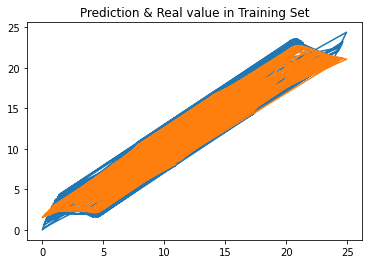

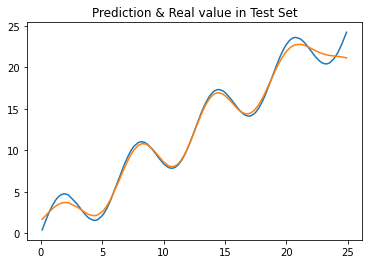

In [156]:
o_x_train = np.loadtxt('train.txt')[:,0]
y_train = np.loadtxt('train.txt')[:,1]

o_x_test = np.loadtxt('test.txt')[:,0]
y_test = np.loadtxt('test.txt')[:,1]

plt.plot(o_x_train, y_train)
plt.plot(o_x_train, pred_train)
plt.title('Prediction & Real value in Training Set')
plt.show()

plt.plot(o_x_test, y_test)
plt.plot(o_x_test, pred_test)
plt.title('Prediction & Real value in Test Set')
plt.show()